In [3]:
import pandas as pd
import datetime
import matplotlib.dates as mdates
import numpy as np
import glob
import os

## 1. Get the list of unpatched devices, their last update date and last OS information

In [4]:
df_unpatched_samsung = pd.read_csv('../Data/Samsung/Samsung_unpatched_devices.csv') 
df_unpatched_xiaomi = pd.read_csv('../Data/Xiaomi/Xiaomi_unpatched_devices.csv') 
df_unpatched_oppo = pd.read_csv('../Data/Oppo/Oppo_unpatched_devices.csv') 
df_unpatched_google = pd.read_csv('../Data/Google/Google_unpatched_devices.csv') 

In [64]:
len(df_unpatched_samsung['device'].unique())

276

In [65]:
len(df_unpatched_xiaomi['device'].unique())

284

In [66]:
len(df_unpatched_oppo['device'].unique())

72

In [67]:
len(df_unpatched_google['device'].unique())

27

## 2. CPEs 

In [7]:
import pandas as pd
import json

def load_data(file_path):
    # Load JSON file
    with open(file_path) as f:
        data = json.load(f)
    
    return data

def create_dataframe(data, chipset_maker):
    # Convert each 'cpe' item to a DataFrame row
    df = pd.DataFrame([product['cpe'] for product in data['products']])

    # Expand 'titles' and 'refs' lists into their own separate columns
    df = df.join(pd.DataFrame(df.pop('titles').tolist()).add_prefix('title_'))
    df = df.join(pd.DataFrame(df.pop('refs').tolist()).add_prefix('ref_'))
    
    # Add chipset_maker column
    df['chipset_maker'] = chipset_maker
    
    return df

# Load data
mediatek_data = load_data('../Data/CPEs/mediatek_cpes.json')
qualcomm_data = load_data('../Data/CPEs/qualcomm_cpes.json')
samsung_data = load_data('../Data/CPEs/samsung_cpes.json')
nvidia_data = load_data('../Data/CPEs/nvidia_cpes.json')
intel_data = load_data('../Data/CPEs/intel_cpes.json')
xiaomi_data = load_data('../Data/CPEs/xiaomi_cpes.json')

# Create dataframes
df_mediatek = create_dataframe(mediatek_data, 'mediatek')
df_qualcomm = create_dataframe(qualcomm_data, 'qualcomm')
df_samsung = create_dataframe(samsung_data, 'samsung')
df_nvidia = create_dataframe(nvidia_data, 'nvidia')
df_intel = create_dataframe(intel_data, 'intel')
df_xiaomi = create_dataframe(xiaomi_data, 'xiaomi')

# Combine dataframes
df_combined = pd.concat([df_mediatek, df_qualcomm, df_samsung, df_nvidia, df_intel, df_xiaomi])

# Print combined dataframe
#print(df_combined)


In [8]:
import pandas as pd
import numpy as np
from urllib.parse import quote

df_samsung = pd.read_excel('../Data/chipsets.xlsx', sheet_name='Samsung')
df_xiaomi = pd.read_excel('../Data/chipsets.xlsx', sheet_name='Xiaomi')
df_oppo = pd.read_excel('../Data/chipsets.xlsx', sheet_name='Oppo')
df_google = pd.read_excel('../Data/chipsets.xlsx', sheet_name='Google')


# Concatenate the columns across all dataframes
all_cpes = pd.concat([df_xiaomi[['cpe1', 'cpe2', 'cpe3', 'cpe4']],
                      df_oppo[['cpe1', 'cpe2', 'cpe3', 'cpe4']],
                      df_google[['cpe1', 'cpe2', 'cpe3', 'cpe4']]], ignore_index=True)

# Flatten the dataframe to a series and remove NaN values
all_cpes = all_cpes.values.flatten()
all_cpes = pd.Series(all_cpes)

# Drop empty and NaN values
all_cpes = all_cpes.replace('', np.nan).dropna()

# Get the unique values
unique_cpes = all_cpes.unique()


base_url = "https://services.nvd.nist.gov/rest/json/cves/2.0?cpeName="

# list to store the urls
urls = []

for cpe in unique_cpes:
    # Append the url to the list
    url = base_url + cpe

    # Remove trailing ellipsis or three dots from the url if present
    if url.endswith("…"):
        url = url[:-1]
    elif url.endswith("..."):
        url = url[:-3]
    
    urls.append(url)
    

In [9]:
import pandas as pd
import os

base_url = "https://services.nvd.nist.gov/rest/json/cves/2.0?cpeName="

# lists to store the cpes, urls, and filenames
cpes = []
urls = []
filenames = []

for cpe in unique_cpes:
    # Generate URL
    url = base_url + cpe
    # Remove trailing ellipsis or three dots from the url if present
    if url.endswith("…"):
        url = url[:-1]
    elif url.endswith("..."):
        url = url[:-3]
    
    urls.append(url)

    # Generate filename
    components = cpe.split(":")
    filename = f"{components[2]}_{components[3]}_{components[4] if components[4] != '-' else ''}.json"
    filenames.append(filename.strip('_'))

    # Add the cpe to the list
    cpes.append(cpe)

# Create a dataframe from the lists
df = pd.DataFrame({
    'cpe': cpes,
    'url': urls,
    'filename': filenames
})


# Your specified directory
folder_path = "../Data/chipset-CVEs/"

# Get the list of all files in the directory
existing_files = os.listdir(folder_path)

# Subtracting the set of all filenames in the directory from the filenames in the DataFrame
missing_files = set(df['filename']) - set(existing_files)

# Create a DataFrame with only the missing files
df_missing_files = df[df['filename'].isin(missing_files)]

print('Existing files: {}'.format(len(existing_files)))
print('Missing files: {}'.format(len(df_missing_files)))


Existing files: 194
Missing files: 0


## Hardware CVEs

In [11]:
path = '../Data/chipset-CVEs/'

files = sorted(glob.glob(path + '*.json'))[:]

print('Combining...')   
d = []
cves_all = []
for file in files[:]:
    print(file)
    base = os.path.basename(file)
    chipset = os.path.splitext(base)[0]
    
    df_new = pd.read_json(file)
    df_new2 = pd.json_normalize(df_new['vulnerabilities'])
    cves = list(set(df_new2['cve.id'].to_list()))
    cves_all = cves_all + cves
    
    cve_count = len(cves)
    cves_str = ','.join(cves)

    d.append({'chipset': chipset, 'cve': cves_str, 'cve_count': cve_count})
    
    
df_chipsets = pd.DataFrame(d)

df_chipsets.head()

Combining...
../Data/chipset-CVEs/h_intel_atom_x5-z8500.json
../Data/chipset-CVEs/h_mediatek_mt6750.json
../Data/chipset-CVEs/h_mediatek_mt6755.json
../Data/chipset-CVEs/h_mediatek_mt6761.json
../Data/chipset-CVEs/h_mediatek_mt6762.json
../Data/chipset-CVEs/h_mediatek_mt6763.json
../Data/chipset-CVEs/h_mediatek_mt6765.json
../Data/chipset-CVEs/h_mediatek_mt6765t.json
../Data/chipset-CVEs/h_mediatek_mt6769.json
../Data/chipset-CVEs/h_mediatek_mt6769z.json
../Data/chipset-CVEs/h_mediatek_mt6771.json
../Data/chipset-CVEs/h_mediatek_mt6779.json
../Data/chipset-CVEs/h_mediatek_mt6795.json
../Data/chipset-CVEs/h_mediatek_mt6797.json
../Data/chipset-CVEs/h_mediatek_mt6833.json
../Data/chipset-CVEs/h_mediatek_mt6853.json
../Data/chipset-CVEs/h_mediatek_mt6875.json
../Data/chipset-CVEs/h_mediatek_mt6877.json
../Data/chipset-CVEs/h_mediatek_mt6889.json
../Data/chipset-CVEs/h_mediatek_mt6893.json
../Data/chipset-CVEs/h_mediatek_mt6983.json
../Data/chipset-CVEs/h_mediatek_mt8176.json
../Data/chips

../Data/chipset-CVEs/qualcomm_sm8150.json
../Data/chipset-CVEs/qualcomm_sm8250.json
../Data/chipset-CVEs/qualcomm_sm8350.json
../Data/chipset-CVEs/qualcomm_sm8450.json
../Data/chipset-CVEs/samsung_exynos_2100.json
../Data/chipset-CVEs/samsung_exynos_5420.json
../Data/chipset-CVEs/samsung_exynos_7420.json
../Data/chipset-CVEs/samsung_exynos_7570.json
../Data/chipset-CVEs/samsung_exynos_7580.json
../Data/chipset-CVEs/samsung_exynos_7870.json
../Data/chipset-CVEs/samsung_exynos_7880.json
../Data/chipset-CVEs/samsung_exynos_7885.json
../Data/chipset-CVEs/samsung_exynos_8890.json
../Data/chipset-CVEs/samsung_exynos_8895.json
../Data/chipset-CVEs/samsung_exynos_9610.json
../Data/chipset-CVEs/samsung_exynos_980.json
../Data/chipset-CVEs/samsung_exynos_9810.json
../Data/chipset-CVEs/samsung_exynos_9820.json
../Data/chipset-CVEs/samsung_exynos_990.json
../Data/chipset-CVEs/unisocsc7730.json
../Data/chipset-CVEs/unisocsc9863a.json


,chipset,cve,cve_count
0,h_intel_atom_x5-z8500,"CVE-2022-0002,CVE-2020-0551,CVE-2022-24436,CVE...",4
1,h_mediatek_mt6750,"CVE-2022-20031,CVE-2021-0425,CVE-2022-21749,CV...",35
2,h_mediatek_mt6755,"CVE-2022-20031,CVE-2022-20072,CVE-2021-0425,CV...",32
3,h_mediatek_mt6761,"CVE-2023-20725,CVE-2022-32591,CVE-2022-32619,C...",193
4,h_mediatek_mt6762,"CVE-2022-32591,CVE-2022-32619,CVE-2022-20090,C...",147


In [12]:
df_nist = pd.read_csv('../Data/NIST_all.csv')

hardware_cve_list = list(set(cves_all))
df_nist_hardware = df_nist[df_nist['cve.CVE_data_meta.ID'].isin(hardware_cve_list)].reset_index(drop=True)
df_nist_hardware['cve.CVE_data_meta.ASSIGNER'].value_counts()

#df_nist_hardware['impact.baseMetricV3.cvssV3.baseSeverity'].value_counts()

security.cna@qualcomm.com      1051
security@mediatek.com           358
security@unisoc.com             127
security@android.com             50
cve@mitre.org                    40
mobile.security@samsung.com      18
secure@intel.com                  4
psirt@nvidia.com                  1
Name: cve.CVE_data_meta.ASSIGNER, dtype: int64

In [13]:
len(hardware_cve_list)

1649

## Assign to the devices

In [14]:
import pandas as pd
from pandas.io.json import json_normalize
import json
import os

# Define the device vendors
vendors = ["Samsung", "Xiaomi", "Oppo", "Google"]

# Initialize an empty DataFrame
df_chipsets_all = pd.DataFrame()

# Loop over each vendor
for vendor in vendors:
    print('vendor: {}'.format(vendor))

    # Read excel file
    df_vendor = pd.read_excel('../Data/chipsets_v2.xlsx', sheet_name=vendor)

    # Add a new column with the vendor name
    df_vendor['vendor'] = vendor

    # Append the data from the vendor to df_chipsets_all
    df_chipsets_all = df_chipsets_all.append(df_vendor, ignore_index=True)

# Replace '\t' with an empty string for string columns
string_columns = ['chipset','cpe1', 'cpe2', 'cpe3', 'cpe4']
for column in string_columns:
    if df_chipsets_all[column].dtype == object:
        df_chipsets_all[column] = df_chipsets_all[column].str.replace('\t', '')

# Save the final DataFrame to an Excel file
df_chipsets_all.to_excel('../Data/chipsets_v3.xlsx', index=False)


vendor: Samsung
vendor: Xiaomi
vendor: Oppo
vendor: Google


In [15]:
import pandas as pd
from pandas.io.json import json_normalize
import json

# read excel file
df_hardware = pd.read_excel('../Data/chipsets_v3.xlsx')


for device in df_hardware['device'][:]:
    
    cpe1 = df_hardware.loc[df_hardware.device==device,'cpe1'].item()
    cpe2 = df_hardware.loc[df_hardware.device==device,'cpe2'].item()
    cpe3 = df_hardware.loc[df_hardware.device==device,'cpe3'].item()
    cpe4 = df_hardware.loc[df_hardware.device==device,'cpe4'].item()
    
    cve_list = []
    
    if pd.isna(cpe1)!=True:
        cpe1 = os.path.splitext(cpe1)[0]
        cve1 = df_chipsets.loc[df_chipsets.chipset==cpe1,'cve'].item()
        cve1_splitted = cve1.split(',')
        cve_list = cve_list + cve1_splitted
        
    if pd.isna(cpe2)!=True:
        cpe2 = os.path.splitext(cpe2)[0]
        cve2 = df_chipsets.loc[df_chipsets.chipset==cpe2,'cve'].item()
        cve2_splitted = cve2.split(',')
        cve_list = cve_list + cve2_splitted

    if pd.isna(cpe3)!=True:
        cpe3 = os.path.splitext(cpe3)[0]
        cve3 = df_chipsets.loc[df_chipsets.chipset==cpe3,'cve'].item()
        cve3_splitted = cve3.split(',')
        cve_list = cve_list + cve3_splitted
    
    if pd.isna(cpe4)!=True:
        cpe4 = os.path.splitext(cpe4)[0]
        cve4 = df_chipsets.loc[df_chipsets.chipset==cpe4,'cve'].item()
        cve4_splitted = cve4.split(',')
        cve_list = cve_list + cve4_splitted


    cve_list_unique = list(set(cve_list))
    cve_list_str = ','.join(cve_list_unique)
    
    df_hardware.at[df_hardware.device==device,'hardware_cves_all'] =  cve_list_str
    df_hardware.at[df_hardware.device==device,'hardware_cves_all_count'] =  len(cve_list_unique)
    
    
df_hardware['hardware_cves_all_count'] = df_hardware['hardware_cves_all_count'].astype(int)

In [16]:
df_hardware[df_hardware['hardware_cves_all_count']>0]

,device,chipset,cpe1,cpe2,cpe3,cpe4,vendor,hardware_cves_all,hardware_cves_all_count
0,Galaxy S21 Ultra 5G,Exynos 2100 (5 nm) - International\nQualcomm S...,samsung_exynos_2100,h_qualcomm_sm8350_firmware,o_qualcomm_sm8350_firmware,NaN,Samsung,"CVE-2020-11130,CVE-2020-11168,CVE-2020-11121,C...",11
1,Galaxy S21+ 5G,Exynos 2100 (5 nm) - International\nQualcomm S...,samsung_exynos_2100,h_qualcomm_sm8350_firmware,o_qualcomm_sm8350_firmware,NaN,Samsung,"CVE-2020-11130,CVE-2020-11168,CVE-2020-11121,C...",11
2,Galaxy S21 5G,Exynos 2100 (5 nm) - International\nQualcomm S...,samsung_exynos_2100,h_qualcomm_sm8350_firmware,o_qualcomm_sm8350_firmware,NaN,Samsung,"CVE-2020-11130,CVE-2020-11168,CVE-2020-11121,C...",11
3,Galaxy Tab S 10.5,Exynos 5420 Octa (28 nm),samsung_exynos_5420,NaN,NaN,NaN,Samsung,"CVE-2017-18696,CVE-2017-18690,CVE-2019-20607,C...",6
4,Galaxy A8 (2016),Exynos 7420 Octa (14 nm),samsung_exynos_7420,NaN,NaN,NaN,Samsung,"CVE-2019-20610,CVE-2019-20601,CVE-2020-13831",3
...,...,...,...,...,...,...,...,...,...
541,Pixel 3 XL,Qualcomm SDM845 Snapdragon 845 (10 nm),o_qualcomm_sdm845_firmware.json,h_qualcomm_sdm845.json,NaN,NaN,Google,"CVE-2020-11202,CVE-2019-10490,CVE-2019-13995,C...",271
542,Nexus 9 (LTE),Nvidia Tegra K1,h_nvidia_tegra_k1.json,o_nvidia_tegra_k1_firmware.json,NaN,NaN,Google,CVE-2017-6278,1
543,Pixel 3a XL,Qualcomm SDM670 Snapdragon 670 (10 nm),h_qualcomm_sdm670.json,o_qualcomm_sdm670_firmware.json,NaN,NaN,Google,"CVE-2020-11202,CVE-2019-10490,CVE-2019-13995,C...",228
546,Pixel C,Nvidia Tegra X1,o_nvidia_tegra_x1_firmware.json,h_nvidia_tegra_x1.json,NaN,NaN,Google,CVE-2017-0866,1


## Android Version CVEs

In [18]:
#Getting the descriptions and other details from NIST for unique Android CVEs
df_nist = pd.read_csv('../Data/NIST_all.csv')
df_aosp = pd.read_csv('../Data/AOSP-bulletins.csv')

df_aosp_with_version = df_aosp[~df_aosp['affected_versions'].isnull()]
df_samsung = df_nist[df_nist['cve.description.description_data'].str.contains('SVE')]

df_nist_android_13 = df_nist[df_nist['cve.description.description_data'].str.contains('Android-13')]['cve.CVE_data_meta.ID'].to_list()
df_aosp_13 = df_aosp_with_version[df_aosp_with_version['affected_versions'].str.contains('13')]['CVE'].to_list()
samsung_android_13 = df_samsung[df_samsung['cve.description.description_data'].str.contains("T(13",regex=False)]['cve.CVE_data_meta.ID'].to_list()
df_android_13 = list(set(df_nist_android_13+df_aosp_13+samsung_android_13))
print('Android-13: {}'.format(len(df_android_13)))

df_nist_android_12 = df_nist[df_nist['cve.description.description_data'].str.contains('Android-12')]['cve.CVE_data_meta.ID'].to_list()
df_aosp_12 = df_aosp_with_version[df_aosp_with_version['affected_versions'].str.contains('12')]['CVE'].to_list()
samsung_android_12 = df_samsung[df_samsung['cve.description.description_data'].str.contains("S(12",regex=False)]['cve.CVE_data_meta.ID'].to_list()
df_android_12 = list(set(df_nist_android_12+df_aosp_12+samsung_android_12))
print('Android-12: {}'.format(len(df_android_12)))

df_nist_android_11 = df_nist[df_nist['cve.description.description_data'].str.contains('Android-11')]['cve.CVE_data_meta.ID'].to_list()
df_aosp_11 = df_aosp_with_version[df_aosp_with_version['affected_versions'].str.contains('11')]['CVE'].to_list()
samsung_android_11 = df_samsung[df_samsung['cve.description.description_data'].str.contains("R(11",regex=False)]['cve.CVE_data_meta.ID'].to_list()
df_android_11 = list(set(df_nist_android_11+df_aosp_11+samsung_android_11))
print('Android-11: {}'.format(len(df_android_11)))

df_nist_android_10 = df_nist[df_nist['cve.description.description_data'].str.contains('Android-10')]['cve.CVE_data_meta.ID'].to_list()
df_aosp_10 = df_aosp_with_version[df_aosp_with_version['affected_versions'].str.contains('10')]['CVE'].to_list()
samsung_android_10 = df_samsung[df_samsung['cve.description.description_data'].str.contains("Q(10",regex=False)]['cve.CVE_data_meta.ID'].to_list()
df_android_10 = list(set(df_nist_android_10+df_aosp_10+samsung_android_10))
print('Android-10: {}'.format(len(df_android_10)))

df_nist_android_9 = df_nist[df_nist['cve.description.description_data'].str.contains('Android-9')]['cve.CVE_data_meta.ID'].to_list()
df_aosp_9 = df_aosp_with_version[df_aosp_with_version['affected_versions'].str.contains('9')]['CVE'].to_list()
samsung_android_9 = df_samsung[df_samsung['cve.description.description_data'].str.contains("P(9",regex=False)]['cve.CVE_data_meta.ID'].to_list()
df_android_9 = list(set(df_nist_android_9+df_aosp_9+samsung_android_9))
print('Android-9: {}'.format(len(df_android_9)))

df_nist_android_8_0 = df_nist[df_nist['cve.description.description_data'].str.contains('Android-8.0')]['cve.CVE_data_meta.ID'].to_list()
df_aosp_8_0 = df_aosp_with_version[df_aosp_with_version['affected_versions'].str.contains('8.0')]['CVE'].to_list()
samsung_android_8 = df_samsung[df_samsung['cve.description.description_data'].str.contains("O(8",regex=False)]['cve.CVE_data_meta.ID'].to_list()
df_android_8_0 = list(set(df_nist_android_8_0+df_aosp_8_0+samsung_android_8))
print('Android-8.0: {}'.format(len(df_android_8_0)))

df_nist_android_8_1 = df_nist[df_nist['cve.description.description_data'].str.contains('Android-8.1')]['cve.CVE_data_meta.ID'].to_list()
df_aosp_8_1 = df_aosp_with_version[df_aosp_with_version['affected_versions'].str.contains('8.1')]['CVE'].to_list()
samsung_android_8 = df_samsung[df_samsung['cve.description.description_data'].str.contains("O(8",regex=False)]['cve.CVE_data_meta.ID'].to_list()
df_android_8_1 = list(set(df_nist_android_8_1+df_aosp_8_1+samsung_android_8))
print('Android-8.1: {}'.format(len(df_android_8_1)))

df_nist_android_7_0 = df_nist[df_nist['cve.description.description_data'].str.contains('Android-7.0')]['cve.CVE_data_meta.ID'].to_list()
df_aosp_7_0 = df_aosp_with_version[df_aosp_with_version['affected_versions'].str.contains('7.0')]['CVE'].to_list()
samsung_android_7 = df_samsung[df_samsung['cve.description.description_data'].str.contains("N(7",regex=False)]['cve.CVE_data_meta.ID'].to_list()
df_android_7_0 = list(set(df_nist_android_7_0+df_aosp_7_0+samsung_android_7))
print('Android-7.0: {}'.format(len(df_android_7_0)))

df_nist_android_7_1_1 = df_nist[df_nist['cve.description.description_data'].str.contains('Android-7.1.1')]['cve.CVE_data_meta.ID'].to_list()
df_aosp_7_1_1 = df_aosp_with_version[df_aosp_with_version['affected_versions'].str.contains('7.1.1')]['CVE'].to_list()
samsung_android_7 = df_samsung[df_samsung['cve.description.description_data'].str.contains("N(7",regex=False)]['cve.CVE_data_meta.ID'].to_list()
df_android_7_1_1 = list(set(df_nist_android_7_1_1+df_aosp_7_1_1+samsung_android_7))
print('Android-7.1.1: {}'.format(len(df_android_7_1_1)))

df_nist_android_6_0_1 = df_nist[df_nist['cve.description.description_data'].str.contains('Android-6.0.1')]['cve.CVE_data_meta.ID'].to_list()
df_aosp_6_0_1 = df_aosp_with_version[df_aosp_with_version['affected_versions'].str.contains('6.0.1')]['CVE'].to_list()
samsung_android_6 = df_samsung[df_samsung['cve.description.description_data'].str.contains("M(6",regex=False)]['cve.CVE_data_meta.ID'].to_list()
df_android_6_0_1 = list(set(df_nist_android_6_0_1+df_aosp_6_0_1+samsung_android_6))
print('Android-6.0.1: {}'.format(len(df_android_6_0_1)))

d_version_all = list(set(df_android_13+df_android_12+df_android_11+df_android_10+df_android_9+df_android_8_0+df_android_8_1+df_android_7_0+df_android_7_1_1+df_android_6_0_1))
df_version_all = df_nist[df_nist['cve.CVE_data_meta.ID'].isin(d_version_all)]
df_version_all['cve.CVE_data_meta.ASSIGNER'].value_counts()



Android-13: 381
Android-12: 426
Android-11: 744
Android-10: 1000
Android-9: 680
Android-8.0: 630
Android-8.1: 676
Android-7.0: 708
Android-7.1.1: 668
Android-6.0.1: 665


security@android.com           2475
cve@mitre.org                   360
secalert@redhat.com              11
cert@cert.org                    11
security@google.com               6
product-security@apple.com        3
chrome-cve-admin@google.com       2
secalert_us@oracle.com            2
talos-cna@cisco.com               2
security@suse.com                 1
security@mozilla.org              1
cve@checkpoint.com                1
psirt@adobe.com                   1
Name: cve.CVE_data_meta.ASSIGNER, dtype: int64

## Samsung - Match the impacting CVEs to devices through the last OS

In [19]:
# create a list of our conditions
conditions = [(df_unpatched_samsung['last_android_version'] == 'T(Android 13)'),
              (df_unpatched_samsung['last_android_version'] == 'S(Android 12)'),
              (df_unpatched_samsung['last_android_version'] == 'R(Android 11)'),
              (df_unpatched_samsung['last_android_version'] == 'Q(Android 10)'),
              (df_unpatched_samsung['last_android_version'] == 'Pie(Android 9)'),
              (df_unpatched_samsung['last_android_version'] == 'Oreo(Android 8.1.0)'),
              (df_unpatched_samsung['last_android_version'] == 'Oreo(Android 8.0.0)'),
              (df_unpatched_samsung['last_android_version'] == 'Nougat(Android 7.0)'),
              (df_unpatched_samsung['last_android_version'] == 'Nougat(Android 7.1.1)'),
              (df_unpatched_samsung['last_android_version'] == 'Marshmallow(Android 6.0.1)')]


# create a list of the values we want to assign for each condition
values = [','.join(df_android_13),
          ','.join(df_android_12),
          ','.join(df_android_11),
          ','.join(df_android_10), 
          ','.join(df_android_9), 
          ','.join(df_android_8_1),
          ','.join(df_android_8_0),
          ','.join(df_android_7_0),
          ','.join(df_android_7_1_1),
          ','.join(df_android_6_0_1)]

# create a list of the values we want to assign for each condition
values2 = [len(df_android_13),
           len(df_android_12),
           len(df_android_11),
           len(df_android_10),
           len(df_android_9),
           len(df_android_8_1),
           len(df_android_8_0),
           len(df_android_7_0),
           len(df_android_7_1_1),
           len(df_android_6_0_1)]

            
# create a new column and use np.select to assign values to it using our lists as arguments
df_unpatched_samsung['version_CVE_list_all'] = np.select(conditions, values)
df_unpatched_samsung['version_CVE_list_all_count'] = np.select(conditions, values2)

df_unpatched_samsung.head()

,id,device,last_android_version,last_update_date,version_CVE_list_all,version_CVE_list_all_count
0,SM-A047F/ACR,Galaxy A04s,T(Android 13),2023-02-17,"CVE-2022-20261,CVE-2022-20493,CVE-2022-42544,C...",381
1,SM-A047F/AFG,Galaxy A04s,T(Android 13),2023-02-17,"CVE-2022-20261,CVE-2022-20493,CVE-2022-42544,C...",381
2,SM-A047F/AFR,Galaxy A04s,T(Android 13),2023-02-17,"CVE-2022-20261,CVE-2022-20493,CVE-2022-42544,C...",381
3,SM-A047F/BOG,Galaxy A04s,T(Android 13),2023-02-13,"CVE-2022-20261,CVE-2022-20493,CVE-2022-42544,C...",381
4,SM-A047F/CAU,Galaxy A04s,T(Android 13),2023-02-17,"CVE-2022-20261,CVE-2022-20493,CVE-2022-42544,C...",381


## Xiaomi - Match the impacting CVEs to devices through the last OS

In [20]:
df_unpatched_xiaomi['last_android_version'] = df_unpatched_xiaomi['last_android_version'].astype(str)

# create a list of our conditions
conditions = [(df_unpatched_xiaomi['last_android_version'] == '13.0'),
              (df_unpatched_xiaomi['last_android_version'] == '12.0'),
              (df_unpatched_xiaomi['last_android_version'] == '11.0'),
              (df_unpatched_xiaomi['last_android_version'] == '10.0'),
              (df_unpatched_xiaomi['last_android_version'] == '9.0'),
              (df_unpatched_xiaomi['last_android_version'] == '8.1'),
              (df_unpatched_xiaomi['last_android_version'] == '8.0'),
              (df_unpatched_xiaomi['last_android_version'] == '7.0'),
              (df_unpatched_xiaomi['last_android_version'] == '7.1'),
              (df_unpatched_xiaomi['last_android_version'] == '6.0')]


# create a list of the values we want to assign for each condition
values = [','.join(df_android_13),
          ','.join(df_android_12),
          ','.join(df_android_11),
          ','.join(df_android_10), 
          ','.join(df_android_9), 
          ','.join(df_android_8_1),
          ','.join(df_android_8_0),
          ','.join(df_android_7_0),
          ','.join(df_android_7_1_1),
          ','.join(df_android_6_0_1)]

# create a list of the values we want to assign for each condition
values2 = [len(df_android_13),
           len(df_android_12),
           len(df_android_11),
           len(df_android_10),
           len(df_android_9),
           len(df_android_8_1),
           len(df_android_8_0),
           len(df_android_7_0),
           len(df_android_7_1_1),
           len(df_android_6_0_1)]

            
# create a new column and use np.select to assign values to it using our lists as arguments
df_unpatched_xiaomi['version_CVE_list_all'] = np.select(conditions, values)
df_unpatched_xiaomi['version_CVE_list_all_count'] = np.select(conditions, values2)

df_unpatched_xiaomi.head()

,codename,name,last_android_version,last_update_date,version_CVE_list_all,version_CVE_list_all_count
0,HM2013022,Redmi 1 TD,4.4,2017-11-15,0,0
1,HM2013023,Redmi 1 W,4.4,2018-09-26,0,0
2,HM2013023_sg_global,Redmi 1 W,4.4,2015-12-24,0,0
3,HM2014011,Redmi 1S TD 3G,4.4,2018-09-07,0,0
4,HM2014501,Redmi 1S TD 4G,4.4,2018-09-07,0,0


## Oppo - Match the impacting CVEs to devices through the last OS

In [21]:
df_unpatched_oppo['last_android_version'] = df_unpatched_oppo['last_android_version'].astype(float)
df_unpatched_oppo['last_android_version'] = df_unpatched_oppo['last_android_version'].astype(str)

# create a list of our conditions
conditions = [(df_unpatched_oppo['last_android_version'] == '13.0'),
              (df_unpatched_oppo['last_android_version'] == '12.0'),
              (df_unpatched_oppo['last_android_version'] == '11.0'),
              (df_unpatched_oppo['last_android_version'] == '10.0'),
              (df_unpatched_oppo['last_android_version'] == '9.0'),
              (df_unpatched_oppo['last_android_version'] == '8.1'),
              (df_unpatched_oppo['last_android_version'] == '8.0'),
              (df_unpatched_oppo['last_android_version'] == '7.0'),
              (df_unpatched_oppo['last_android_version'] == '7.1'),
              (df_unpatched_oppo['last_android_version'] == '6.0')]


# create a list of the values we want to assign for each condition
values = [','.join(df_android_13),
          ','.join(df_android_12),
          ','.join(df_android_11),
          ','.join(df_android_10), 
          ','.join(df_android_9), 
          ','.join(df_android_8_1),
          ','.join(df_android_8_0),
          ','.join(df_android_7_0),
          ','.join(df_android_7_1_1),
          ','.join(df_android_6_0_1)]

# create a list of the values we want to assign for each condition
values2 = [len(df_android_13),
           len(df_android_12),
           len(df_android_11),
           len(df_android_10),
           len(df_android_9),
           len(df_android_8_1),
           len(df_android_8_0),
           len(df_android_7_0),
           len(df_android_7_1_1),
           len(df_android_6_0_1)]

            
# create a new column and use np.select to assign values to it using our lists as arguments
df_unpatched_oppo['version_CVE_list_all'] = np.select(conditions, values)
df_unpatched_oppo['version_CVE_list_all_count'] = np.select(conditions, values2)

df_unpatched_oppo.head()

,url,device,last_android_version,last_update_date,version_CVE_list_all,version_CVE_list_all_count
0,https://support.oppo.com/dz/software-update/so...,OPPO Reno2 F,11.0,2021-05-10,"CVE-2021-0968,CVE-2022-20493,CVE-2020-0340,CVE...",744
1,https://support.oppo.com/dz/software-update/so...,OPPO Reno3,11.0,2021-01-05,"CVE-2021-0968,CVE-2022-20493,CVE-2020-0340,CVE...",744
2,https://support.oppo.com/dz/software-update/so...,OPPO A9 2020,11.0,2021-07-26,"CVE-2021-0968,CVE-2022-20493,CVE-2020-0340,CVE...",744
3,https://support.oppo.com/dz/software-update/so...,OPPO A11k,11.0,2022-03-30,"CVE-2021-0968,CVE-2022-20493,CVE-2020-0340,CVE...",744
4,https://support.oppo.com/dz/software-update/so...,OPPO A12,11.0,2022-03-30,"CVE-2021-0968,CVE-2022-20493,CVE-2020-0340,CVE...",744


## Google - Match the impacting CVEs to devices through the last OS

In [22]:
df_unpatched_google['last_android_version'] = df_unpatched_google['last_android_version'].astype(str)

# create a list of our conditions
conditions = [(df_unpatched_google['last_android_version'] == '13.0.0'),
              (df_unpatched_google['last_android_version'] == '12.1.0'),
              (df_unpatched_google['last_android_version'] == '12.0.0'),
              (df_unpatched_google['last_android_version'] == '11.0.0'),
              (df_unpatched_google['last_android_version'] == '10.0.0'),
              (df_unpatched_google['last_android_version'] == '9.0.0'),
              (df_unpatched_google['last_android_version'] == '8.1.0'),
              (df_unpatched_google['last_android_version'] == '8.0.0'),
              (df_unpatched_google['last_android_version'] == '7.0.0'),
              (df_unpatched_google['last_android_version'] == '7.1.0'),
              (df_unpatched_google['last_android_version'] == '6.0.0')]


# create a list of the values we want to assign for each condition
values = [','.join(df_android_13),
          ','.join(df_android_12),
          ','.join(df_android_12),
          ','.join(df_android_11),
          ','.join(df_android_10), 
          ','.join(df_android_9), 
          ','.join(df_android_8_1),
          ','.join(df_android_8_0),
          ','.join(df_android_7_0),
          ','.join(df_android_7_1_1),
          ','.join(df_android_6_0_1)]

# create a list of the values we want to assign for each condition
values2 = [len(df_android_13),
           len(df_android_12),
           len(df_android_12),
           len(df_android_11),
           len(df_android_10),
           len(df_android_9),
           len(df_android_8_1),
           len(df_android_8_0),
           len(df_android_7_0),
           len(df_android_7_1_1),
           len(df_android_6_0_1)]

            
# create a new column and use np.select to assign values to it using our lists as arguments
df_unpatched_google['version_CVE_list_all'] = np.select(conditions, values)
df_unpatched_google['version_CVE_list_all_count'] = np.select(conditions, values2)

df_unpatched_google.head()

,codename,device,last_android_version,last_update_date,version_CVE_list_all,version_CVE_list_all_count
0,cheetah,Pixel 7 Pro,13.0.0,2023-03-01,"CVE-2022-20261,CVE-2022-20493,CVE-2022-42544,C...",381
1,panther,Pixel 7,13.0.0,2023-03-01,"CVE-2022-20261,CVE-2022-20493,CVE-2022-42544,C...",381
2,bluejay,Pixel 6a,13.0.0,2023-03-01,"CVE-2022-20261,CVE-2022-20493,CVE-2022-42544,C...",381
3,oriole,Pixel 6,13.0.0,2023-03-01,"CVE-2022-20261,CVE-2022-20493,CVE-2022-42544,C...",381
4,raven,Pixel 6 Pro,13.0.0,2023-03-01,"CVE-2022-20261,CVE-2022-20493,CVE-2022-42544,C...",381


In [23]:
df_unpatched_xiaomi.rename(columns={"name": "device"},inplace=True)
df_unpatched_xiaomi.rename(columns={"codename": "id"},inplace=True)
df_unpatched_oppo.rename(columns={"url": "id"},inplace=True)
df_unpatched_google.rename(columns={"codename": "id"},inplace=True)

In [24]:
# First, add a 'vendor' column to each DataFrame
df_unpatched_xiaomi['vendor'] = 'xiaomi'
df_unpatched_oppo['vendor'] = 'oppo'
df_unpatched_google['vendor'] = 'google'
df_unpatched_samsung['vendor'] = 'samsung'

# Then, concatenate the DataFrames vertically
df_unpatched_all = pd.concat([df_unpatched_xiaomi, df_unpatched_oppo, df_unpatched_google, df_unpatched_samsung], ignore_index=True)


In [25]:
df_unpatched_all.head()

,id,device,last_android_version,last_update_date,version_CVE_list_all,version_CVE_list_all_count,vendor
0,HM2013022,Redmi 1 TD,4.4,2017-11-15,0,0,xiaomi
1,HM2013023,Redmi 1 W,4.4,2018-09-26,0,0,xiaomi
2,HM2013023_sg_global,Redmi 1 W,4.4,2015-12-24,0,0,xiaomi
3,HM2014011,Redmi 1S TD 3G,4.4,2018-09-07,0,0,xiaomi
4,HM2014501,Redmi 1S TD 4G,4.4,2018-09-07,0,0,xiaomi


## Combine Android version and hardware CVEs

In [26]:
df_unpatched_merged = df_unpatched_all.merge(df_hardware[['device', 'chipset','hardware_cves_all', 'hardware_cves_all_count']], 
                                   on='device', 
                                   how='left')

df_unpatched_merged.head()

,id,device,last_android_version,last_update_date,version_CVE_list_all,version_CVE_list_all_count,vendor,chipset,hardware_cves_all,hardware_cves_all_count
0,HM2013022,Redmi 1 TD,4.4,2017-11-15,0,0,xiaomi,NaN,,0.0
1,HM2013023,Redmi 1 W,4.4,2018-09-26,0,0,xiaomi,NaN,,0.0
2,HM2013023_sg_global,Redmi 1 W,4.4,2015-12-24,0,0,xiaomi,NaN,,0.0
3,HM2014011,Redmi 1S TD 3G,4.4,2018-09-07,0,0,xiaomi,Qualcomm MSM8228 Snapdragon 400 (28 nm),,0.0
4,HM2014501,Redmi 1S TD 4G,4.4,2018-09-07,0,0,xiaomi,Qualcomm MSM8228 Snapdragon 400 (28 nm),,0.0


In [28]:
from tqdm.notebook import tqdm
import numpy as np

tqdm.pandas()

def process_row(row):
    version_CVE_list_all = row['version_CVE_list_all'].split(',')
    version_CVE_list_all_count = len(version_CVE_list_all)
    
    if row['hardware_cves_all_count']>0:
        hardware_cves_all_splitted = row['hardware_cves_all'].split(',')
        CVE_list_all_splitted = list(set(hardware_cves_all_splitted + version_CVE_list_all))
        CVE_list_all_splitted_count = row['hardware_cves_all_count'] + version_CVE_list_all_count
    else:
        CVE_list_all_splitted = version_CVE_list_all
        CVE_list_all_splitted_count = version_CVE_list_all_count

    row['CVE_list_all'] = ','.join(CVE_list_all_splitted)
    row['CVE_list_all_count'] = CVE_list_all_splitted_count
    
    return row

df_unpatched_merged['version_CVE_list_all_count'] = df_unpatched_merged['version_CVE_list_all'].apply(lambda x: len(x.split(',')))
df_unpatched_merged['CVE_list_all'] = ''
df_unpatched_merged['CVE_list_all_count'] = np.zeros(len(df_unpatched_merged), dtype=int)

df_unpatched_merged = df_unpatched_merged.progress_apply(process_row, axis=1)

df_unpatched_merged.head()

  0%|          | 0/23388 [00:00<?, ?it/s]

In [29]:
df_unpatched_merged['version_CVE_list_all_count'] = df_unpatched_merged['version_CVE_list_all_count'].astype(int)
df_unpatched_merged['hardware_cves_all_count'] = df_unpatched_merged['hardware_cves_all_count'].fillna(0).astype(int)
df_unpatched_merged['CVE_list_all_count'] = df_unpatched_merged['CVE_list_all_count'].astype(int)

df_unpatched_merged['last_update_date'] = pd.to_datetime(df_unpatched_merged['last_update_date'])

## Align the EOLs and divide into quarters

In [30]:
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
from tqdm.notebook import tqdm

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
tqdm.pandas()

def get_cves(df_cves_filtered, start, end):
    cves = df_cves_filtered[(df_cves_filtered['days_after_eol'] < end) & 
                            (df_cves_filtered['days_after_eol'] >= start)]['cve.CVE_data_meta.ID'].unique()
    return ','.join(cves)

df_nist = pd.read_csv('../Data/NIST_all.csv')
df_nist['publishedDate']= pd.to_datetime(df_nist['publishedDate'],utc=True)

df_unpatched_merged['CVE_list_filtered'] = ''

def process_row(row):
    CVE_list_all = row['CVE_list_all']
    CVE_list_all_splitted = CVE_list_all.split(',')
    
    df_cves = df_nist[df_nist['cve.CVE_data_meta.ID'].isin(CVE_list_all_splitted)]
    EOL_date = row['last_update_date']
    
    df_cves_filtered = df_cves[df_cves['publishedDate'].dt.date>EOL_date.date()]
    cves_filtered = df_cves_filtered['cve.CVE_data_meta.ID'].unique()

    if len(cves_filtered)==0:
        return row

    CVE_list_filtered = ','.join(cves_filtered)
    
    row['CVE_list_filtered'] = CVE_list_filtered
    row['CVE_list_filtered_count'] = len(cves_filtered)
    
    df_cves_filtered['days_after_eol'] = (df_cves_filtered['publishedDate'].dt.date-EOL_date.date()).dt.days
    
    # Set the ranges for 'days_after_eol'
    ranges = [(i*90, (i+1)*90) for i in range(30)] # Change this for different ranges

    for i, (start, end) in enumerate(ranges):
        row[f'CVE_list_q{i+1}'] = get_cves(df_cves_filtered, start, end)
    
    row['days_after_eol_max'] = df_cves_filtered['days_after_eol'].max()
    row['max_quarter_count'] = round(df_cves_filtered['days_after_eol'].max()/90)
    
    return row

df_unpatched_merged = df_unpatched_merged.progress_apply(process_row, axis=1)


  0%|          | 0/23388 [00:00<?, ?it/s]

In [68]:
len(df_unpatched_merged['device'].unique())

659

In [70]:
len(df_unpatched_merged[df_unpatched_merged['max_quarter_count']>1]['device'].unique())

432

In [41]:
df_unpatched_merged.groupby('vendor')['CVE_list_filtered_count'].mean()

vendor
google     257.629630
oppo       502.270979
samsung    142.324290
xiaomi     132.227513
Name: CVE_list_filtered_count, dtype: float64

### Case Study: "Galaxy Z Fold3 5G"

In [86]:
df_unpatched_merged[(df_unpatched_merged['vendor']=='samsung')&(df_unpatched_merged['max_quarter_count']==3)]['device'].unique()[:50]

array(['Galaxy A13', 'Galaxy A13 5G', 'Galaxy A21', 'Galaxy A31',
       'Galaxy S21 FE 5G', 'Galaxy XCover Pro', 'Galaxy Z Flip',
       'Galaxy Z Flip3 5G', 'Galaxy Z Fold3 5G', 'Galaxy XCover 4s',
       'Galaxy A10', 'Galaxy A12', 'Galaxy A20', 'Galaxy A20e',
       'Galaxy A50', 'Galaxy A70', 'Galaxy A80', 'Galaxy A02',
       'Galaxy A02s', 'Galaxy A03', 'Galaxy A03 Core', 'Galaxy A03s',
       'Galaxy A10s', 'Galaxy M21', 'Galaxy M31', 'Galaxy A6',
       'Galaxy A6+', 'Galaxy A7 (2018)', 'Galaxy J4', 'Galaxy J6',
       'Galaxy J8', 'Galaxy Note9', 'Galaxy S9', 'Galaxy S9+',
       'Galaxy J5 (2017)', 'Galaxy A7 (2017)', 'Galaxy A33 5G',
       'Galaxy A42 5G', 'Galaxy A51 5G', 'Galaxy J7 (2017)',
       'Galaxy J7 Pop', 'Galaxy On7 (2018)', 'W2018', 'Galaxy Note8',
       'Galaxy S8', 'Galaxy S8+', 'Galaxy S6', 'Galaxy S6 edge',
       'Galaxy Grand Prime Plus', 'Galaxy A5 (2015)'], dtype=object)

In [116]:
df_fold = df_unpatched_merged[(df_unpatched_merged['device']=='Galaxy Z Fold3 5G')&(df_unpatched_merged['max_quarter_count']==3)]

In [98]:
df_fold[['id','hardware_cves_all_count','version_CVE_list_all_count','CVE_list_filtered_count','CVE_list_filtered']]

,id,hardware_cves_all_count,version_CVE_list_all_count,CVE_list_filtered_count,CVE_list_filtered
4865,SM-F926U1/TMB,11,426,142.0,"CVE-2022-20213,CVE-2022-20214,CVE-2022-20215,C..."
4866,SM-F926U1/TMK,11,426,142.0,"CVE-2022-20213,CVE-2022-20214,CVE-2022-20215,C..."
4869,SM-F926U1/XAA,11,426,142.0,"CVE-2022-20213,CVE-2022-20214,CVE-2022-20215,C..."
4870,SM-F926U1/XAG,11,426,142.0,"CVE-2022-20213,CVE-2022-20214,CVE-2022-20215,C..."


In [122]:

fold_cves = df_fold[df_fold.id=='SM-F926U1/TMB']['CVE_list_filtered'].to_list()

fold_cves_unique = fold_cves[0].split(',')

df_fold_V2 = df_nist[df_nist['cve.CVE_data_meta.ID'].isin(fold_cves_unique)]


In [128]:
df_fold_V2[(df_fold_V2['impact.baseMetricV3.cvssV3.baseSeverity']=='CRITICAL')&(df_fold_V2['impact.baseMetricV3.cvssV3.attackVector']=='NETWORK')]

,publishedDate,lastModifiedDate,cve.data_type,cve.data_format,cve.data_version,cve.CVE_data_meta.ID,cve.CVE_data_meta.ASSIGNER,cve.problemtype.problemtype_data,cve.references.reference_data,cve.description.description_data,...,impact.baseMetricV3.cvssV3.privilegesRequired,impact.baseMetricV3.cvssV3.userInteraction,impact.baseMetricV3.cvssV3.scope,impact.baseMetricV3.cvssV3.confidentialityImpact,impact.baseMetricV3.cvssV3.integrityImpact,impact.baseMetricV3.cvssV3.availabilityImpact,impact.baseMetricV3.cvssV3.baseScore,impact.baseMetricV3.cvssV3.baseSeverity,impact.baseMetricV3.exploitabilityScore,impact.baseMetricV3.impactScore
178069,2022-12-13 16:15:00+00:00,2022-12-15T04:03Z,CVE,MITRE,4.0,CVE-2022-20472,security@android.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://source.android.com/security/...,"[{'lang': 'en', 'value': 'In toLanguageTag of ...",...,NONE,NONE,UNCHANGED,HIGH,HIGH,HIGH,9.8,CRITICAL,3.9,5.9
178070,2022-12-13 16:15:00+00:00,2022-12-15T04:04Z,CVE,MITRE,4.0,CVE-2022-20473,security@android.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://source.android.com/security/...,"[{'lang': 'en', 'value': 'In toLanguageTag of ...",...,NONE,NONE,UNCHANGED,HIGH,HIGH,HIGH,9.8,CRITICAL,3.9,5.9
201535,2023-02-28 17:15:00+00:00,2023-03-06T19:30Z,CVE,MITRE,4.0,CVE-2023-20946,security@android.com,"[{'description': [{'lang': 'en', 'value': 'NVD...",[{'url': 'https://source.android.com/security/...,"[{'lang': 'en', 'value': 'In onStart of Blueto...",...,NONE,NONE,UNCHANGED,HIGH,HIGH,HIGH,9.8,CRITICAL,3.9,5.9
201541,2023-03-24 20:15:00+00:00,2023-03-29T07:31Z,CVE,MITRE,4.0,CVE-2023-20951,security@android.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://source.android.com/security/...,"[{'lang': 'en', 'value': 'In gatt_process_prep...",...,NONE,NONE,UNCHANGED,HIGH,HIGH,HIGH,9.8,CRITICAL,3.9,5.9
201544,2023-03-24 20:15:00+00:00,2023-03-29T15:00Z,CVE,MITRE,4.0,CVE-2023-20954,security@android.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://source.android.com/security/...,"[{'lang': 'en', 'value': 'In SDP_AddAttribute ...",...,NONE,NONE,UNCHANGED,HIGH,HIGH,HIGH,9.8,CRITICAL,3.9,5.9
201692,2023-04-19 20:15:00+00:00,2023-04-25T22:12Z,CVE,MITRE,4.0,CVE-2023-21096,security@android.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://source.android.com/security/...,"[{'lang': 'en', 'value': 'In OnWakelockRelease...",...,NONE,NONE,UNCHANGED,HIGH,HIGH,HIGH,9.8,CRITICAL,3.9,5.9


In [ ]:
df_fold = df_unpatched_merged[(df_unpatched_merged['device']=='Galaxy Z Fold3 5G')&(df_unpatched_merged['max_quarter_count']==3)]

### Calculate the statistics for quarters

In [33]:
from collections import Counter

df_final = df_unpatched_merged.copy()

d = []
critical_sum = 0
high_sum = 0
medium_sum = 0
low_sum = 0

cve_per_pair_accumulated = 0
critical_per_pair_accumulated = 0
high_per_pair_accumulated = 0
medium_per_pair_accumulated = 0
low_per_pair_accumulated = 0


cond1 = ~df_final['CVE_list_filtered'].isnull()
cond2 = df_final['CVE_list_filtered']!=''
cond3 = df_final['CVE_list_filtered_count']>0
df_final_v2 = df_final[cond1&cond2&cond3]

print('{} unsupported devices'.format(len(df_final_v2.index)))

for i in range(1,31):
    
    q = 'CVE_list_q'+str(i)
    
    cond1 = ~df_final_v2[q].isnull()
    cond2 = df_final_v2[q]!=''
    cond3 = df_final_v2['max_quarter_count']>=(i-1)

    df_final_active = df_final_v2[cond1&cond2&cond3]
    
    pair_count=len(df_final_active['id'].unique())
    #model_count=len(df_final_active['device'].unique())
    #device_count=len(df_final_active['device'].unique())
        
    q_cves_all = []
    for l in df_final_active[q].str.split(','):
        q_cves_all = q_cves_all + l
        
    q_cves_unique = list(set(q_cves_all))

    df_q = df_nist[df_nist['cve.CVE_data_meta.ID'].isin(q_cves_all)]
    
    total_cve_count = len(q_cves_all)
    unique_cve_count = len(q_cves_unique)
    
    if pair_count==0:
        cve_per_pair=0
    else:
        cve_per_pair = total_cve_count/pair_count
    
    cve_per_pair_accumulated = cve_per_pair_accumulated + cve_per_pair

    #SEVERITY
    # Convert the list to a Counter
    counter_q_cves_all = Counter(q_cves_all)
    # Now, for each 'critical_cves', look up its count in 'counter_q_cves_all'
    critical_cves = df_q[df_q['impact.baseMetricV3.cvssV3.baseSeverity']=='CRITICAL']['cve.CVE_data_meta.ID'].tolist()
    critical_count = sum(counter_q_cves_all[cve] for cve in critical_cves)
    # Now, for each 'high_cves', look up its count in 'counter_q_cves_all'
    high_cves = df_q[df_q['impact.baseMetricV3.cvssV3.baseSeverity']=='HIGH']['cve.CVE_data_meta.ID'].tolist()
    high_count = sum(counter_q_cves_all[cve] for cve in high_cves)
    # Now, for each 'medium_cves', look up its count in 'counter_q_cves_all'
    medium_cves = df_q[df_q['impact.baseMetricV3.cvssV3.baseSeverity']=='MEDIUM']['cve.CVE_data_meta.ID'].tolist()
    medium_count = sum(counter_q_cves_all[cve] for cve in medium_cves)
    # Now, for each 'low_cves', look up its count in 'counter_q_cves_all'
    low_cves = df_q[df_q['impact.baseMetricV3.cvssV3.baseSeverity']=='LOW']['cve.CVE_data_meta.ID'].tolist()
    low_count = sum(counter_q_cves_all[cve] for cve in low_cves)
    
        
    if pair_count==0:
        critical_per_pair=0
        high_per_pair=0
        medium_per_pair=0
        low_per_pair=0
    else:
        critical_per_pair = critical_count/pair_count
        high_per_pair = high_count/pair_count
        medium_per_pair = medium_count/pair_count
        low_per_pair = low_count/pair_count
    
    critical_per_pair_accumulated = critical_per_pair_accumulated + critical_per_pair
    high_per_pair_accumulated = high_per_pair_accumulated + high_per_pair
    medium_per_pair_accumulated = medium_per_pair_accumulated + medium_per_pair
    low_per_pair_accumulated = low_per_pair_accumulated + low_per_pair
    
    
    #USER INTERACTION
    none_count = len(df_q[df_q['impact.baseMetricV3.cvssV3.userInteraction']=='NONE'].index)
    required_count = len(df_q[df_q['impact.baseMetricV3.cvssV3.userInteraction']=='REQUIRED'].index)
    
    if pair_count==0:
        none_per=0
        required_per=0
    else:     
        none_per = (none_count*100)/(none_count+required_count)
        required_per = (required_count*100)/(none_count+required_count)
    
    
    #COMPLEXITY
    low_comp_count = len(df_q[df_q['impact.baseMetricV2.cvssV2.accessComplexity']=='LOW'].index)
    medium_comp_count = len(df_q[df_q['impact.baseMetricV2.cvssV2.accessComplexity']=='MEDIUM'].index)
    high_comp_count = len(df_q[df_q['impact.baseMetricV2.cvssV2.accessComplexity']=='HIGH'].index)
        
    if pair_count==0:
        low_comp_per=0
        medium_comp_per=0
        high_com_per=0
    else:     
        low_comp_per = (low_comp_count*100)/(low_comp_count+medium_comp_count+high_comp_count)
        medium_comp_per = (medium_comp_count*100)/(low_comp_count+medium_comp_count+high_comp_count)
        high_com_per = (high_comp_count*100)/(low_comp_count+medium_comp_count+high_comp_count)
    
    
    #ATTACK VECTOR
    local_count = len(df_q[df_q['impact.baseMetricV3.cvssV3.attackVector']=='LOCAL'].index)
    adjacent_network_count = len(df_q[df_q['impact.baseMetricV3.cvssV3.attackVector']=='ADJACENT_NETWORK'].index)
    network_count = len(df_q[df_q['impact.baseMetricV3.cvssV3.attackVector']=='NETWORK'].index)
    physical_count = len(df_q[df_q['impact.baseMetricV3.cvssV3.attackVector']=='PHYSICAL'].index)
    
    if pair_count==0:
        local_per=0
        adjacent_network_per=0
        network_per=0
        physical_per=0
    else:     
        local_per = (local_count*100)/(local_count+adjacent_network_count+network_count+physical_count)
        adjacent_network_per = (adjacent_network_count*100)/(local_count+adjacent_network_count+network_count+physical_count)
        network_per = (network_count*100)/(local_count+adjacent_network_count+network_count+physical_count)
        physical_per = (physical_count*100)/(local_count+adjacent_network_count+network_count+physical_count)
    
    #EXTRA 
    #userInteraction=='NONE' & Severity=='CRITICAL'
    none_critical_count = len(df_q[(df_q['impact.baseMetricV3.cvssV3.userInteraction']=='NONE')&(df_q['impact.baseMetricV3.cvssV3.baseSeverity']=='CRITICAL')].index)
        
    if pair_count==0:
        none_critical_count_per=0
    else:
        none_critical_count_per = (none_critical_count*100)/(none_count+required_count)
    
    #userInteraction=='NONE' & Severity=='HIGH'
    none_high_count = len(df_q[(df_q['impact.baseMetricV3.cvssV3.userInteraction']=='NONE')&(df_q['impact.baseMetricV3.cvssV3.baseSeverity']=='HIGH')].index)
    
    if pair_count==0:
        none_high_count_per=0
    else:
        none_high_count_per = (none_high_count*100)/(none_count+required_count)
    
    
    d.append({'period': i, 
              'total_cve_count': total_cve_count,
              'unique_cve_count': unique_cve_count,
              'pair_count': pair_count,
              'cve_per_pair':cve_per_pair,
              'cve_per_pair_accumulated':cve_per_pair_accumulated,
              'critical_count': critical_count,
              'high_count':high_count,
              'medium_count':medium_count,
              'low_count':low_count,
              'critical_per_pair':critical_per_pair,
              'high_per_pair':high_per_pair,
              'medium_per_pair':medium_per_pair,
              'low_per_pair':low_per_pair,
              'critical_per_pair_accumulated':critical_per_pair_accumulated,
              'high_per_pair_accumulated':high_per_pair_accumulated,
              'medium_per_pair_accumulated':medium_per_pair_accumulated,
              'low_per_pair_accumulated':low_per_pair_accumulated,
              'none_count':none_count,
              'required_count':required_count,
              'none_per': none_per,
              'required_per': required_per,
              'low_comp_count': low_comp_count,
              'medium_comp_per': medium_comp_per,
              'high_comp_count': high_comp_count,
              'low_comp_per': low_comp_per,
              'high_com_per': high_com_per,
              'local_count': local_count,
              'network_count': network_count,
              'local_per': local_per,
              'adjacent_network_per':adjacent_network_per,
              'network_per': network_per,
              'physical_per':physical_per,
              'none_critical_count': none_critical_count,
              'none_critical_count_per': none_critical_count_per,
              'none_high_count': none_high_count,
              'none_high_count_per':none_high_count_per
             })
    
df_quarters = pd.DataFrame(d)
df_quarters.head()

19947 unsupported devices
Completed i: 1
Completed i: 2
Completed i: 3
Completed i: 4
Completed i: 5
Completed i: 6
Completed i: 7
Completed i: 8
Completed i: 9
Completed i: 10
Completed i: 11
Completed i: 12
Completed i: 13
Completed i: 14
Completed i: 15
Completed i: 16
Completed i: 17
Completed i: 18
Completed i: 19
Completed i: 20
Completed i: 21
Completed i: 22
Completed i: 23
Completed i: 24
Completed i: 25
Completed i: 26
Completed i: 27
Completed i: 28
Completed i: 29
Completed i: 30


,period,total_cve_count,unique_cve_count,pair_count,cve_per_pair,cve_per_pair_accumulated,critical_count,high_count,medium_count,low_count,...,local_count,network_count,local_per,adjacent_network_per,network_per,physical_per,none_critical_count,none_critical_count_per,none_high_count,none_high_count_per
0,1,1493580,3062,19460,76.751285,76.751285,67093,748028,662235,14873,...,2067,855,67.571102,2.778686,27.950311,1.699902,371,12.128146,1102,36.024845
1,2,429314,2601,12560,34.181051,110.932336,24939,234383,165146,3924,...,1718,758,66.127791,2.848345,29.176289,1.847575,345,13.279446,976,37.567360
2,3,253773,2330,6208,40.878383,151.810718,33497,128563,85729,5383,...,1462,758,62.827675,2.449506,32.574130,2.148689,336,14.439192,864,37.129351
3,4,328130,2125,5062,64.822205,216.632923,78814,143074,92999,12584,...,1346,675,63.430726,2.450518,31.809614,2.309142,307,14.467484,826,38.925542
4,5,220588,2050,4291,51.407131,268.040054,48944,95652,68131,7190,...,1292,658,63.116756,2.442599,32.144602,2.296043,306,14.948705,796,38.886175


### Severity

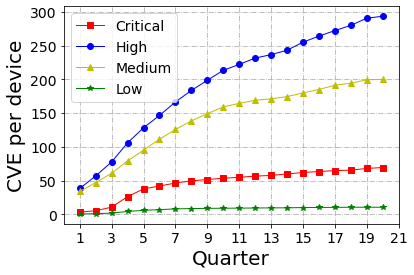

,critical_per_pair_accumulated,high_per_pair_accumulated,medium_per_pair_accumulated,low_per_pair_accumulated
period,,,,
1,3.447739,38.439260,34.030576,0.764286
2,5.433328,57.100327,47.179142,1.076706
3,10.829108,77.809573,60.988582,1.943813
4,26.398843,106.073895,79.360569,4.429787
5,37.805042,128.365203,95.238220,6.105387
6,42.056609,146.624177,111.395770,7.078037
7,46.535170,166.524927,125.854241,8.234858
8,49.724801,183.684886,138.491349,8.658119
9,51.716638,198.612777,149.217426,8.991452


<Figure size 432x288 with 0 Axes>

In [34]:
import pandas as pd 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df_plot = df_quarters[df_quarters['period'] < 21][['period','critical_per_pair_accumulated','high_per_pair_accumulated','medium_per_pair_accumulated','low_per_pair_accumulated']]

df_plot.set_index('period',inplace=True)
styles = ['rs-','bo-','y^-','g*-']
df_plot.plot(style=styles,linewidth=1)
plt.xlabel('Quarter',fontsize=20)
plt.ylabel('CVE per device',fontsize=20)
plt.xticks(list(range(1, 22, 2)),list(range(1, 22, 2)),fontsize=14)
plt.yticks(fontsize=14)
plt.grid(linestyle='-.')
plt.legend(['Critical','High','Medium','Low'],fontsize=14,loc=2)
plt.xlim(0, 21)
plt.savefig('../Results/unsupported_severity_v2.pdf', bbox_inches='tight')
plt.show()
plt.tight_layout()


df_plot

In [35]:
df_plot['critical_per_pair_accumulated']+df_plot['high_per_pair_accumulated']+df_plot['medium_per_pair_accumulated']+df_plot['low_per_pair_accumulated']

period
1      76.681860
2     110.789504
3     151.571076
4     216.263095
5     267.513852
6     307.154593
7     347.149196
8     380.559155
9     408.538293
10    435.473391
11    450.990264
12    466.936522
13    475.400181
14    487.542751
15    507.360010
16    523.046141
17    539.069397
18    550.680508
19    568.805508
20    573.680508
dtype: float64

### User Interaction

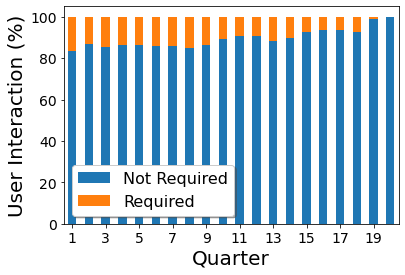

,none_per,required_per
period,,
1,83.360575,16.639425
2,86.720554,13.279446
3,85.302965,14.697035
4,86.333648,13.666352
5,86.419150,13.580850
6,85.989583,14.010417
7,85.919540,14.080460
8,85.045514,14.954486
9,86.398964,13.601036


<Figure size 432x288 with 0 Axes>

In [36]:
import pandas as pd 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df_plot = df_quarters[df_quarters['period'] < 21][['period','none_per','required_per']]
df_plot.set_index('period',inplace=True)

df_plot.plot(kind='bar',stacked=True)
plt.xlabel('Quarter',fontsize=20)
plt.ylabel('User Interaction (%)',fontsize=20)
plt.xticks(fontsize=14,rotation = 0)
plt.yticks(fontsize=14)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(20))
plt.legend(['Not Required','Required'],fontsize=16,loc=3,shadow=True)
plt.savefig('../Results/unsupported_user_interaction_v2.pdf', bbox_inches='tight')
plt.show()
plt.tight_layout()

df_plot


### Attack Complexity

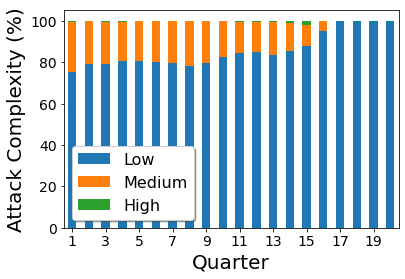

,low_comp_per,medium_comp_per,high_com_per
period,,,
1,75.372182,24.159932,0.467886
2,79.327157,20.380302,0.292540
3,79.242424,20.252525,0.505051
4,80.581459,19.034558,0.383982
5,80.650685,19.063927,0.285388
6,79.987760,19.706242,0.305998
7,79.630895,20.027341,0.341763
8,78.056680,21.700405,0.242915
9,79.560261,20.114007,0.325733


<Figure size 432x288 with 0 Axes>

In [37]:
import pandas as pd 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df_plot = df_quarters[df_quarters['period'] < 21][['period','low_comp_per','medium_comp_per','high_com_per']]

df_plot.set_index('period',inplace=True)
hatches = ["*", "/", "o", "x"]

bars = df_plot.plot(kind='bar',stacked=True)
plt.xlabel('Quarter',fontsize=20)
plt.ylabel('Attack Complexity (%)',fontsize=20)
plt.xticks(fontsize=14,rotation = 0)
plt.yticks(fontsize=14)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(20))
plt.legend(['Low','Medium','High'],fontsize=16,loc=3,shadow=True)
plt.savefig('../Results/unsupported_attack_complexity_v2.pdf', bbox_inches='tight')
plt.show()
plt.tight_layout()

df_plot

### Attack Vector

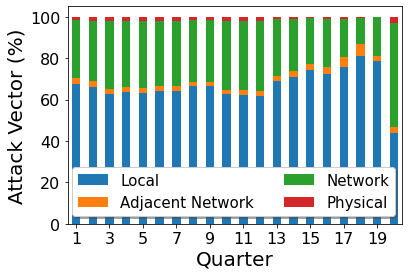

,local_per,adjacent_network_per,network_per,physical_per
period,,,,
1,67.571102,2.778686,27.950311,1.699902
2,66.127791,2.848345,29.176289,1.847575
3,62.827675,2.449506,32.574130,2.148689
4,63.430726,2.450518,31.809614,2.309142
5,63.116756,2.442599,32.144602,2.296043
6,64.166667,2.500000,31.406250,1.927083
7,64.310345,2.068966,31.551724,2.068966
8,66.775033,1.885566,29.713914,1.625488
9,66.580311,2.072539,29.987047,1.360104


<Figure size 432x288 with 0 Axes>

In [38]:
import pandas as pd 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df_plot = df_quarters[df_quarters['period'] < 21][['period','local_per','adjacent_network_per','network_per','physical_per']]
df_plot.set_index('period',inplace=True)
df_plot.plot(kind='bar',stacked=True,sort_columns=True)

plt.xlabel('Quarter',fontsize=20)
plt.ylabel('Attack Vector (%)',fontsize=20)
plt.xticks(fontsize=16,rotation = 0)
plt.yticks(fontsize=16)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(20))
plt.legend(['Local','Adjacent Network','Network','Physical'],fontsize=15,loc=4,ncol=2,shadow=True)
plt.savefig('../Results/unsupported_attack_vector_v2.pdf', bbox_inches='tight')
plt.show()
plt.tight_layout()

df_plot